In [1]:
import numpy as np
import scipy
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.style.use('ggplot')
%matplotlib inline
from tqdm import tqdm
from multitest import MultiTest


# To Do (30/4/2023)
 - Find an estimator to the log-chisqaured parameters (eg. based on moments)
  - mean of sqrt only works when $\mu$ is very large

In [2]:
from scipy.interpolate import interp1d
import pandas as pd

In [3]:
import numpy as np

In [4]:
def fit_pval_func(xx, G = 501):
    qq = np.linspace(0, 1, G)
    yy = [np.quantile(xx, q) for q in qq]
    return interp1d(yy, 1-qq, fill_value = (1,0), bounds_error=False)

def pval_per_sentence(texts, model, tokenizer, pval_func):
    pvals = []
    for text in texts:
        x = logloss(model, tokenizer, text)
        pval = pval_func()
        pvals.append(pval)
    return pvals


100%|██████████| 10000/10000 [00:00<00:00, 17981.93it/s]


## To do: understand why the unstable HC version is much higher under the null

In [19]:
nMonte = 10000
nn = [20, 50, 100, 200, 300]
res = np.zeros((len(nn), nMonte))

for i,n in enumerate(nn):
    for j in tqdm(range(nMonte)):
        uu = np.random.rand(n)
        mt = MultiTest(uu, stbl=True)
        res[i,j] = mt.hc()[0]

def bootstrap_standard_error(xx, alpha, nBS = 1000):
    xxBS_vec = np.random.choice(xx, size=len(xx)*nBS, replace=True)
    xxBS = xxBS_vec.reshape([len(xx), -1])
    return np.quantile(xxBS, 1 - alpha, axis=0).std()

for al in [0.05, 0.01]:
    print(f"alpha={al}: n={nn}")
    for i,n in enumerate(nn):
        sBS = bootstrap_standard_error(res[i], 1 - al)
        print(f"{np.round(np.quantile(res[i], 1 - al), 3)} ({np.round(sBS,2)})", end=" | ")
    print()

alpha=0.05: n=[20, 50, 100, 200, 300]
1.439 (0.02) | 1.713 (0.02) | 1.916 (0.02) | 2.065 (0.02) | 2.129 (0.02) | 
alpha=0.01: n=[20, 50, 100, 200, 300]
1.701 (0.04) | 2.051 (0.05) | 2.323 (0.06) | 2.544 (0.03) | 2.56 (0.04) | 


In [54]:
model_name = "gpt2-xl"
dataset = "wiki-long"
context = "no_context"
folder = "~/Google Drive/results/"
name = f"{model_name}_{context}_{dataset}"
data_machine = pd.read_csv(f"{folder}/{name}_machine.csv")
data_human = pd.read_csv(f"{folder}/{name}_human.csv")

In [55]:
datar = pd.concat([data_machine, data_human])
if 'wiki' in dataset:
    data_machine['author'] = 'GPT3'
    data_human['author'] = 'Wikipedia'
if 'news' in dataset:
    data_machine['author'] = 'ChatGPT'
    data_human['author'] = 'CNN/DailyMail'

datar = pd.concat([data_machine, data_human])
datar = datar[datar['length'] <= 60]

if 'num' in datar.columns:
    datar = datar[datar.num>1]
elif 'sent_num' in datar.index:
    datar = datar[datar.sent_num>1]
else:
    print("Error: I don't know where running number info is")

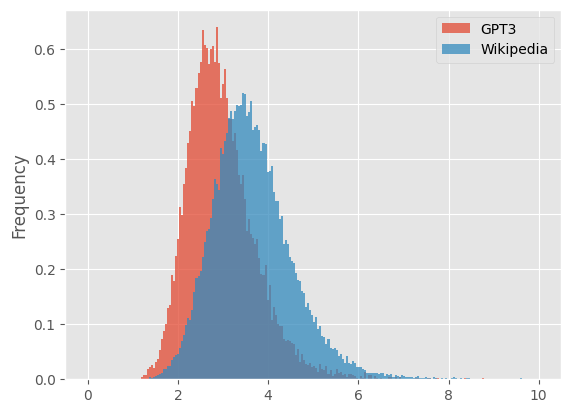

In [56]:
from scipy.stats import norm
tt = np.linspace(0,10,223)
datar.groupby('author').response.plot.hist(bins = tt, density=True, alpha=.75, legend=True)
plt.show()

## Under normal approximation:
$$
Z_1 \sim N(\mu_1, \sigma^2),\quad Z_2 \sim N(\mu_2, \sigma^2)
$$
$$
Z = \frac{Z_1 - Z_2}{\sqrt{2}\sigma} \sim N(\mu_1 - \mu_2 , 1) 
$$


In [44]:
m1, m2 = datar.groupby('author').response.mean()
s1, s2 = datar.groupby('author').response.std()
s = np.sqrt((s1 ** 2 + s2 ** 2) /2)
m = (m2 - m1) / s / np.sqrt(2)
print(f"s = {s}, m = {m}")

s = 0.8091493302017501, m = 0.5624049103636953


In [253]:
n = 100
r = m**2 / 2 / np.log(n)

print("r_hat = ", r)

def rho_inv(r):
    if r > 1: return np.nan
    return (r + 1/2) * (r < .25) + (1 - (1 - np.sqrt(r))**2) * (r >= 0.25) 

beta = rho_inv(r)
print("beta needed: ", beta)

r_hat =  0.0878223136242802
beta needed:  0.5878223136242802


## Estimate log-chisquared params:

$$
-2\log P(x) = (\mu + \sigma Z)^2,\qquad \mu = \sqrt{2 r \log(n)}
$$
Hence
$$
\hat{\mu} = \mathrm{ave}_i\{ \sqrt{-2 \log P(x_i)}  \},\qquad \hat{r} = \hat{\mu}^2/ (2 \log(n))
$$
$$
\hat{\sigma}^2 = \mathrm{var}_i \{ \sqrt{-2 \log P(x_i)}  \}
$$


In [216]:
def fit_pval_func(xx, G = 501):
    qq = np.linspace(0, 1, G)
    yy = [np.quantile(xx, q) for q in qq]
    return interp1d(yy, 1-qq, fill_value = (1,0), bounds_error=False)

In [217]:
pval_func = fit_pval_func(datam[datam.author == 'gpt'].response)

In [221]:
px = pval_func(datam[datam.author=='gpt'].response)

In [272]:
n = 10000
mu_hat = np.mean(np.sqrt(-2 * np.log(np.mean(px))))
rh = mu_hat ** 2 / 2 / np.log(n)
a = np.sqrt(-2 * np.log(px + 1e-10))
sh = np.std(a[~np.isnan(a)])
print(f"r_h = {rh}")
print(f"sigma_h = {sh}")

print("HERE!! we actually need to use non-unit standard deviation to evaluate beta")

print("r_hat = ", rh)

def rho_inv(r):
    if r > 1: return np.nan
    return (r + 1/2) * (r < .25) + (1 - (1 - np.sqrt(r))**2) * (r >= 0.25)

beta = rho_inv(rh)
print("beta needed: ", beta)
print("Epsilon: ", n ** ( - beta))

r_h = 0.07525733267703319
sigma_h = 0.6531460676028922
HERE!! we actually need to use non-unit standard deviation to evaluate beta
r_hat =  0.07525733267703319
beta needed:  0.5752573326770332
Epsilon:  0.005000007655592983


<ipython-input-272-b68362bc47be>:4: RuntimeWarning: invalid value encountered in sqrt
  a = np.sqrt(-2 * np.log(px + 1e-10))


In [269]:
n ** -beta = al

In [270]:
- beta * log(n) = log(al)

0.015811412509952556

array([0.27895368, 0.38353781, 0.05115706, ..., 0.26169788, 0.42610204,
       0.86905629])

In [62]:
pval_func = {}
for c in data_gpt.groupby(['length']):
    pval_func[c[0]] = fit_pval_func(c[1].logloss)

In [39]:
def pval_per_sentence(texts, model, tokenizer, pval_func):
    pvals = []
    for text in texts:
        x = logloss(model, tokenizer, text)
        pval = pval_func()
        pvals.append(pval) 
    return pvals

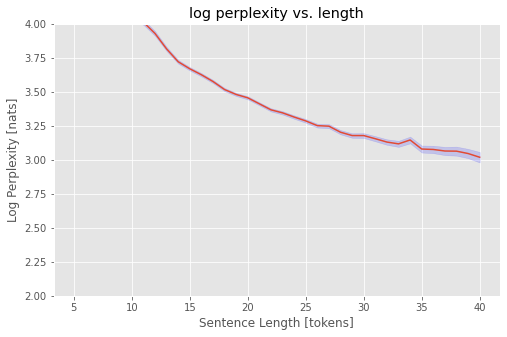

In [77]:
def plot_perp_vs_len(data, min_len=5, max_len=40):
    df_grouped = (
        data[['length', 'logloss']][(data['length'] >= min_len) 
                                        & (data['length'] <= max_len)
                                       ].groupby(['length']).agg(['mean', 'std', 'count'])
    )
    df_grouped = df_grouped.droplevel(axis=1, level=0).reset_index()
    # Calculate a confidence interval as well.
    df_grouped['ci'] = 1.96 * df_grouped['std'] / np.sqrt(df_grouped['count'])
    df_grouped['ci_lower'] = df_grouped['mean'] - df_grouped['ci']
    df_grouped['ci_upper'] = df_grouped['mean'] + df_grouped['ci']
    df_grouped.head()


    fig, ax = plt.subplots()
    x = df_grouped['length']
    ax.plot(x, df_grouped['mean'])
    ax.fill_between(
        x, df_grouped['ci_lower'], df_grouped['ci_upper'], color='b', alpha=.15)
    ax.set_ylim(ymin=0)
    ax.set_title('log perplexity vs. length')
    ax.set_xlabel("Sentence Length [tokens]")
    ax.set_ylabel("Log Perplexity [nats]")
    ax.set_ylim((2,4))
    plt.rcParams["figure.figsize"] = (8,5)
    

plot_perp_vs_len(data_gpt, min_len=5, max_len=40)
plt.savefig("logperp_vs_len_gpt.png")
plt.show()

length
5     Axes(0.125,0.125;0.775x0.755)
10    Axes(0.125,0.125;0.775x0.755)
20    Axes(0.125,0.125;0.775x0.755)
Name: logloss, dtype: object

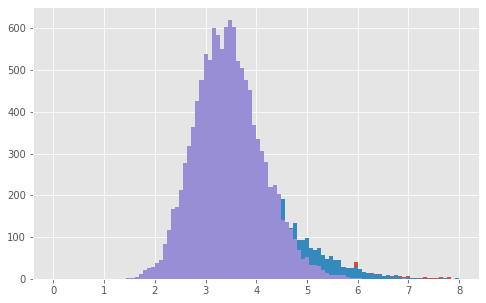

In [90]:
data_gpt[data_gpt.length.isin([5, 10, 20])].groupby('length').logloss.hist(bins=np.linspace(0,8,101))